### Introduction

In the previous post, we implemented the upsampling and made sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we had _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.

In this post we will perform a simple training: we will get a sample image from
[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset along with annotation,
train our network on them and test our network on the same image. It was done this way
so that it can also be run on CPU -- it takes only 10 iterations for the training to complete.
Another point of this post is to show that segmentation that our network (FCN-32s) produces is
very coarse -- even if we run it on the same image that we were training it on. In this post
we tackle this problem by performing Conditional Random Field post-processing stage, which
refines our segmentation by taking into account pure RGB features of image and probabilities
produced by our network. Overall, we get a refined segmentation. The set-up of this post
is very simple on purpose. Similar approach to Segmentation was described in the paper
_Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al.

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.12_.
You will need to use [this fork of _tensorflow/models_](https://github.com/tensorflow/models/pull/684). 

I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

Follow all the other steps described in the previous posts -- it shows how to download
the _VGG-16_ model and I also forked the 

In [1]:
%matplotlib inline

from __future__ import division
import os
import tensorflow as tf
import numpy as np
from nets import vgg
from matplotlib import pyplot as plt
from preprocessing import vgg_preprocessing
from libs.training import get_labels_from_annotation
# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)
slim = tf.contrib.slim

# Data processing

In [2]:
class_semantic_labels = {
    0:   "background",
    1:   "aeroplane",
    2:   "bicycle",
    3:   "bird",
    4:   "boat",
    5:   "bottle",
    6:   "bus",
    7:   "car",
    8:   "cat",
    9:   "chair",
    10:  "cow",
    11:  "diningtable",
    12:  "dog",
    13:  "horse",
    14:  "motorbike",
    15:  "person",
    16:  "pottedplant",
    17:  "sheep",
    18:  "sofa",
    19:  "train",
    20:  "tvmonitor",
    255: "undefined/don't care"
}
number_of_classes = 21
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

### Upsampling helper functions and Image Loading

In this part, we define helper functions that were used in previous post.
If you recall, we used upsampling to upsample the downsampled predictions
that we get from our network. We get downsampled predictions because of max-pooling
layers that are used in _VGG-16_ network.

We also write code for image and respective ground-truth segmentation loading.
The code is well-commented, so don't be afraid to read it.

In [3]:
checkpoints_dir = '/home/thalles/image-segmentation/vgg'
log_folder = '/home/thalles/log_folder'
vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

In [4]:
def model_input():
    is_training_placeholder = tf.placeholder(tf.bool)
    return is_training_placeholder

### Loss function definition and training using Adam Optimization Algorithm.

In [5]:
def model(processed_images, number_of_classes=21, is_training=True):
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        _, end_points = vgg.vgg_16(processed_images,
                                         num_classes=number_of_classes,
                                         is_training=True,
                                         spatial_squeeze=False,
                                         scope='vgg_16')

    input_shape = tf.shape(processed_images)

    #vgg_fc6_feature = end_points['vgg_16/fc6']

    # get the vggs pool5 feature map
    pool5_feature_map = end_points['vgg_16/pool5']
    pool5_feature_shape = tf.shape(pool5_feature_map)

    pool4_feature_map = end_points['vgg_16/pool4']
    pool4_feature_shape = tf.shape(pool4_feature_map)

    pool3_feature_map = end_points['vgg_16/pool3']
    pool3_feature_shape = tf.shape(pool3_feature_map)

    pool2_feature_map = end_points['vgg_16/pool2']
    pool2_feature_shape = tf.shape(pool2_feature_map)

    pool1_feature_map = end_points['vgg_16/pool1']
    pool1_feature_shape = tf.shape(pool1_feature_map)

    with tf.variable_scope("seg_vars"):

        # Merging Pooling 4 layer
        pool5_feature_resized = tf.image.resize_images(pool5_feature_map, 
                                                       [pool4_feature_shape[1], pool4_feature_shape[2]], method=0)
        pool5_feature_conv = slim.conv2d(pool5_feature_resized, 
                                         number_of_classes, 
                                         [1, 1], 
                                         activation_fn=None)

        pool4_feature_conv = slim.conv2d(pool4_feature_map,
                                   number_of_classes,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer,
                                   scope='seg_vars/pool4')

        pool5_conv_plus_poo4_conv = pool5_feature_conv + pool4_feature_conv

        # Merging Pooling 3 layer
        pool4_feature_resized = tf.image.resize_images(pool5_conv_plus_poo4_conv, 
                                                       (pool3_feature_shape[1], pool3_feature_shape[2]), method=0)
        
        pool4_feature_conv = slim.conv2d(pool4_feature_resized, 
                                         number_of_classes, 
                                         [1, 1], 
                                         activation_fn=None)


        pool3_feature_conv = slim.conv2d(pool3_feature_map,
                                   number_of_classes,
                                   [1, 1],
                                   activation_fn=None,
                                   normalizer_fn=None,
                                   weights_initializer=tf.zeros_initializer,
                                   scope='seg_vars/pool3')

        pool4_conv_plus_pool3_conv = pool4_feature_conv + pool3_feature_conv

        # Merging Pooling 2 layer
        pool3_feature_resized = tf.image.resize_images(pool4_conv_plus_pool3_conv, 
                                                       (pool2_feature_shape[1], pool2_feature_shape[2]), method=0)
        
        pool3_feature_conv = slim.conv2d(pool3_feature_resized, 
                                         number_of_classes, 
                                         [1, 1],
                                         activation_fn=None)

        pool2_feature_conv = slim.conv2d(pool2_feature_map,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               weights_initializer=tf.zeros_initializer)

        pool3_conv_plus_pool2_conv = pool3_feature_conv + pool2_feature_conv

        # Merging Pooling1 layer
        pool2_feature_resized = tf.image.resize_images(pool3_conv_plus_pool2_conv, 
                                                       (pool1_feature_shape[1], pool1_feature_shape[2]), method=0)
        
        pool2_feature_conv = slim.conv2d(pool2_feature_resized, 
                                         number_of_classes, 
                                         [1, 1], 
                                         activation_fn=None)

        pool1_feature_conv = slim.conv2d(pool1_feature_map,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               weights_initializer=tf.zeros_initializer)

        pool2_conv_plus_pool1_conv = pool2_feature_conv + pool1_feature_conv

        # Resize to original image shape
        orignal_image_shape = tf.image.resize_images(pool2_conv_plus_pool1_conv, 
                                                       (input_shape[1], input_shape[2]), method=0)
        
        orignal_image_logits = slim.conv2d(orignal_image_shape, 
                                         number_of_classes, 
                                         [1, 1], 
                                         activation_fn=None)

        return orignal_image_logits

In [6]:
def model_loss(upsampled_by_factor_16_logits, labels):

    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=upsampled_by_factor_16_logits,
                                                              labels=labels)

    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
    probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)
    
    return cross_entropy_mean, pred, probabilities

In [7]:
def model_optimizer(cross_entropy_sum, learning_rate):
    # Here we define an optimizer and put all the variables
    # that will be created under a namespace of 'adam_vars'.
    # This is done so that we can easily access them later.
    # Those variables are used by adam optimizer and are not
    # related to variables of the vgg model.

    # We also retrieve gradient Tensors for each of our variables
    # This way we can later visualize them in tensorboard.
    # optimizer.compute_gradients and optimizer.apply_gradients
    # is equivalent to running:
    # train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
    with tf.variable_scope("adam_vars"):
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_sum)
    return train_step

In [8]:
num_classes = 21
input_shape = (384,384,3)
annotation_shape = (384,384)
total_epochs = 30
batch_size = 20
image_size=[384, 384]
total_train_steps = 50

In [9]:
training_filenames = "/home/thalles/VOC2012/ImageSets/Segmentation/train.txt"
training_images_dir = "/home/thalles/VOC2012/JPEGImages/"
training_labels_dir = "/home/thalles/VOC2012/SegmentationClass_1D/"

In [10]:
file = open(training_filenames, 'r')
images_filenale_list = [line for line in file]

In [11]:
# samples a random image to test
import random
random_image_id = random.randint(0, len(images_filenale_list))
image_name = images_filenale_list[random_image_id]
print("Chosen image:", image_name)
#image_name = "2008_000505"

Chosen image: 2009_000535



In [12]:
# read the input and annotation images
image_tensor = tf.read_file(training_images_dir + image_name.strip() + ".jpg")
image_tensor = tf.image.decode_jpeg(image_tensor, channels=3) 
image_tensor = tf.cast(image_tensor, tf.float32)
image_tensor = _mean_image_subtraction(image_tensor,[_R_MEAN, _G_MEAN, _B_MEAN])
image_tensor = tf.expand_dims(image_tensor, axis=0) # (1, ?, ?, 3) # BATCH,WIDTH,HEIGHTxDEPTH

annotation_tensor = tf.read_file(training_labels_dir + image_name.strip() + ".png")
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)
annotation_masks_tensor = get_labels_from_annotation(tf.squeeze(annotation_tensor), class_labels)
annotation_masks_tensor = tf.expand_dims(annotation_masks_tensor, axis=0) # BATCH,WIDTH,HEIGHT

In [13]:
#with tf.Session() as sess:
#    image = sess.run(image_tensor)
#    print(image)

In [14]:
is_training_placeholder = model_input()

upsampled_by_factor_16_logits = model(image_tensor, number_of_classes=number_of_classes, is_training=is_training_placeholder)

cross_entropy_sum, pred, probabilities = model_loss(upsampled_by_factor_16_logits, annotation_masks_tensor)

train_step = model_optimizer(cross_entropy_sum, learning_rate=0.00001)

In [15]:
# Define the accuracy metric: Mean Intersection Over Union
miou, update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=annotation_tensor,
                                                   num_classes=number_of_classes)

acc, acc_update_op = slim.metrics.streaming_accuracy(predictions=pred, 
                                                labels=annotation_tensor, 
                                                name="pixel_accuracy")

In [16]:
# get all segmentation model vars, these are the variables we create to perform 
# the segmentation upsampling layers
model_variables = [ var.op.name for var in slim.get_variables(scope="seg_vars") ]

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
exclude_vars = model_variables + ['vgg_16/fc8', 'adam_vars']
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=exclude_vars)

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# get the segmentation upsampling variables to be initialized 
model_variables = slim.get_variables(scope="seg_vars")

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# the VGG net variables.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

INFO:tensorflow:Restoring parameters from /home/thalles/image-segmentation/vgg/vgg_16.ckpt


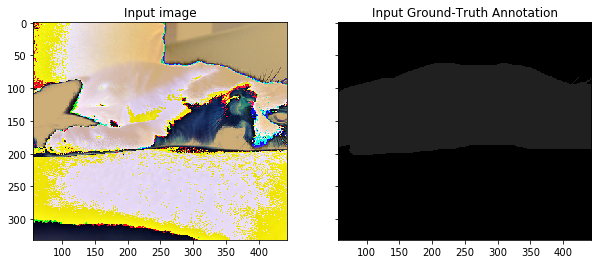

Train step: 0 	Traing Loss: 12.8086 	mIOU: 0.0055618


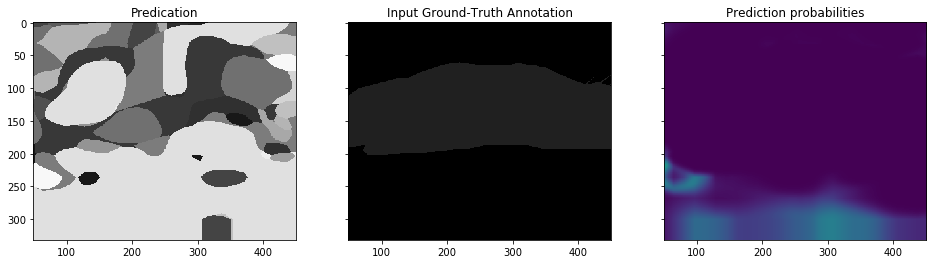

Train step: 1 	Traing Loss: 6.50769 	mIOU: 0.0105647


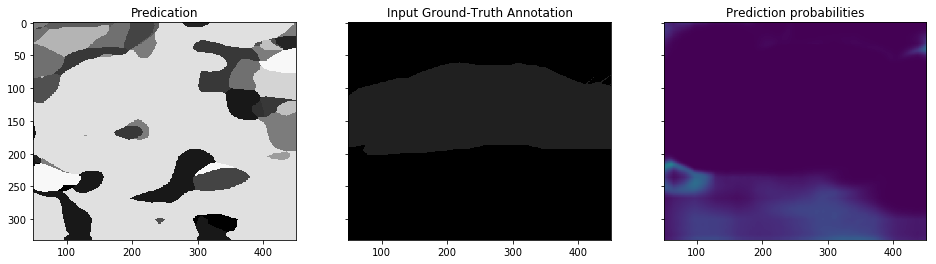

Train step: 2 	Traing Loss: 3.38779 	mIOU: 0.0162648


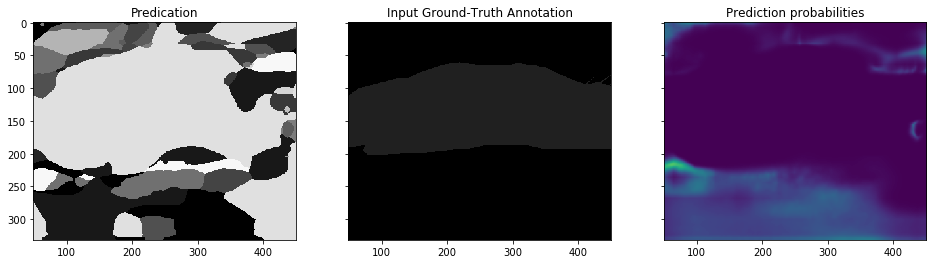

Train step: 3 	Traing Loss: 1.94813 	mIOU: 0.0238805


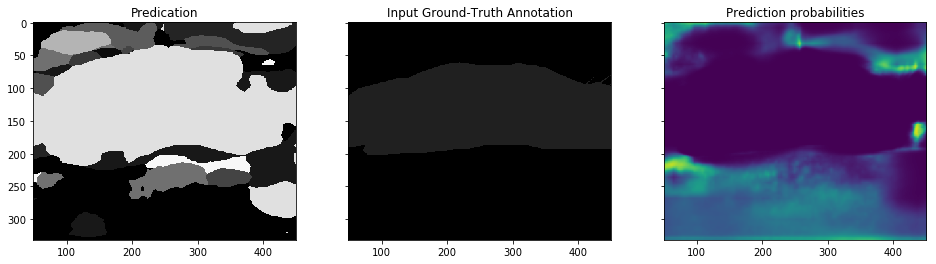

Train step: 4 	Traing Loss: 0.99261 	mIOU: 0.0319355


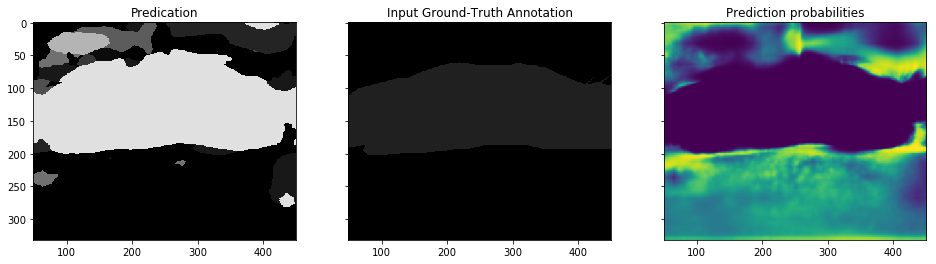

Train step: 5 	Traing Loss: 0.563468 	mIOU: 0.0389798


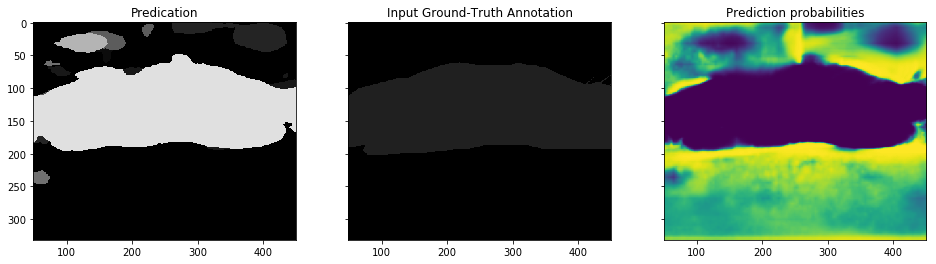

Train step: 6 	Traing Loss: 0.465272 	mIOU: 0.0444355


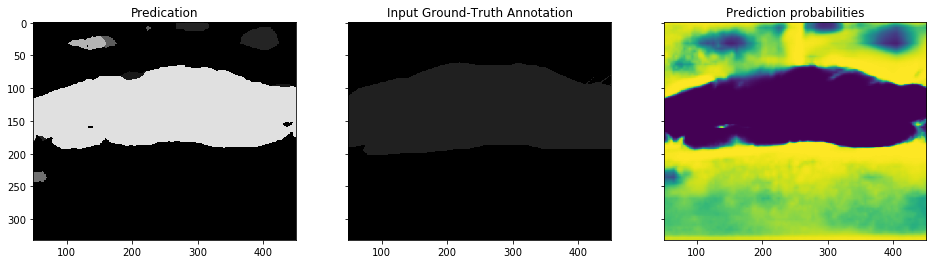

Train step: 7 	Traing Loss: 0.434202 	mIOU: 0.0486117


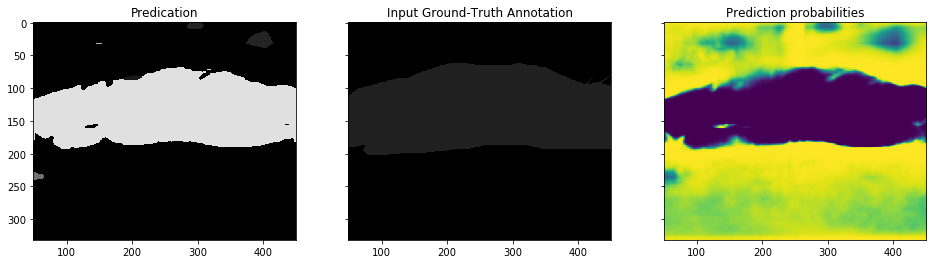

Train step: 8 	Traing Loss: 0.372943 	mIOU: 0.0520082


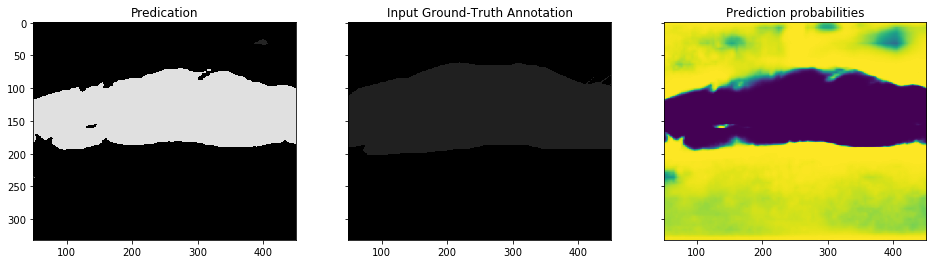

Train step: 9 	Traing Loss: 0.286076 	mIOU: 0.0549468


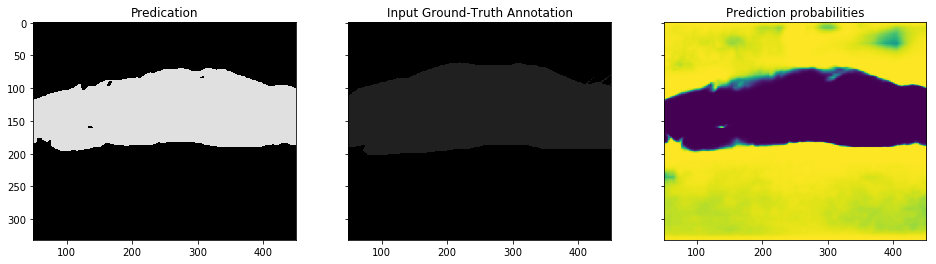

Train step: 10 	Traing Loss: 0.199964 	mIOU: 0.0575531


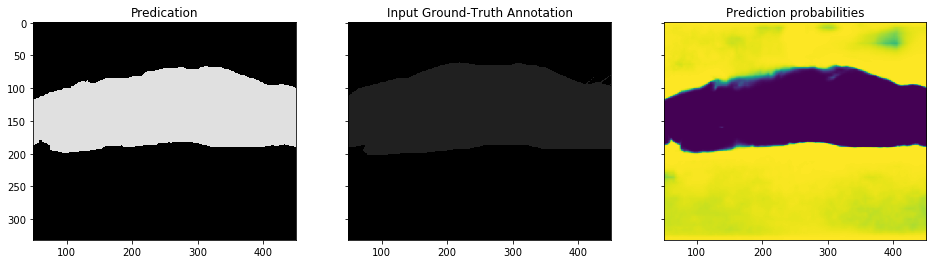

Train step: 11 	Traing Loss: 0.134261 	mIOU: 0.0598907


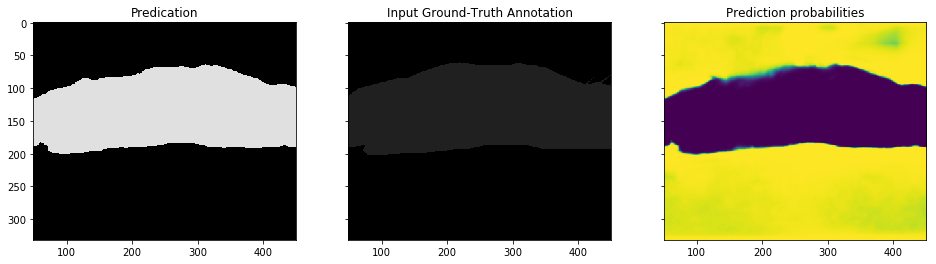

Train step: 12 	Traing Loss: 0.098317 	mIOU: 0.0619911


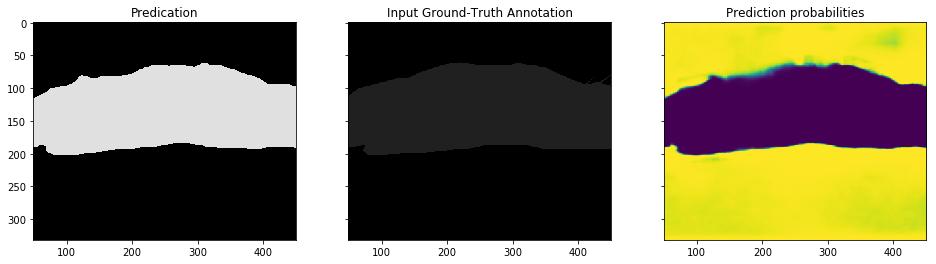

Train step: 13 	Traing Loss: 0.0908503 	mIOU: 0.0638404


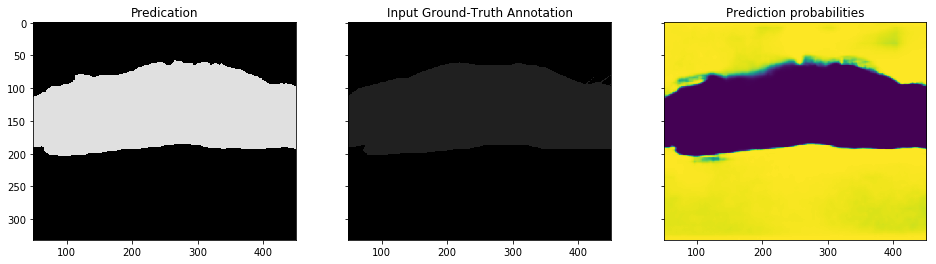

Train step: 14 	Traing Loss: 0.102424 	mIOU: 0.065419


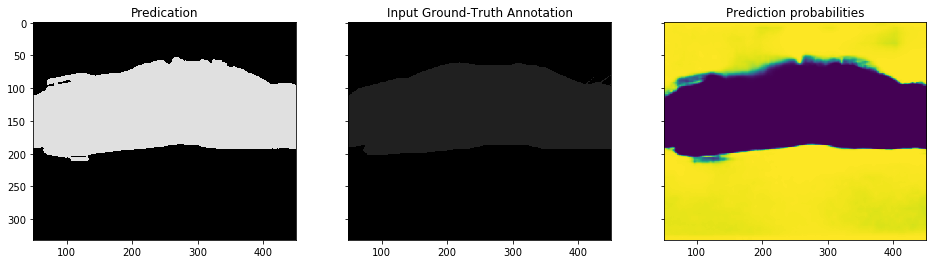

Train step: 15 	Traing Loss: 0.113237 	mIOU: 0.0667938


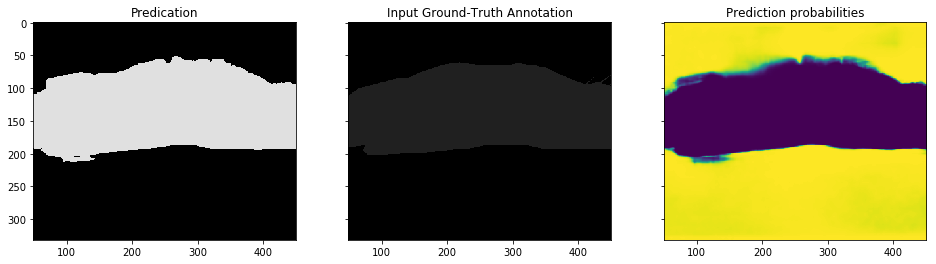

Train step: 16 	Traing Loss: 0.109243 	mIOU: 0.0680331


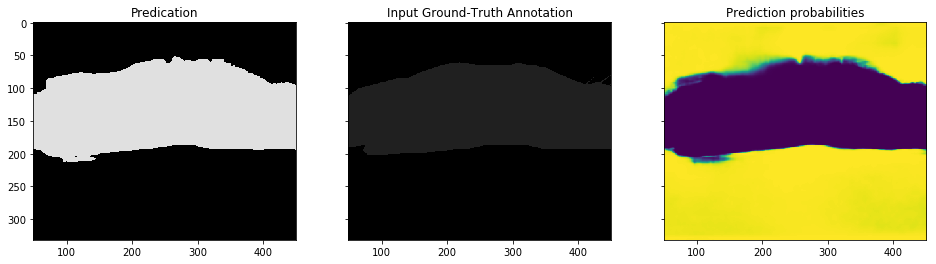

Train step: 17 	Traing Loss: 0.0920516 	mIOU: 0.069183


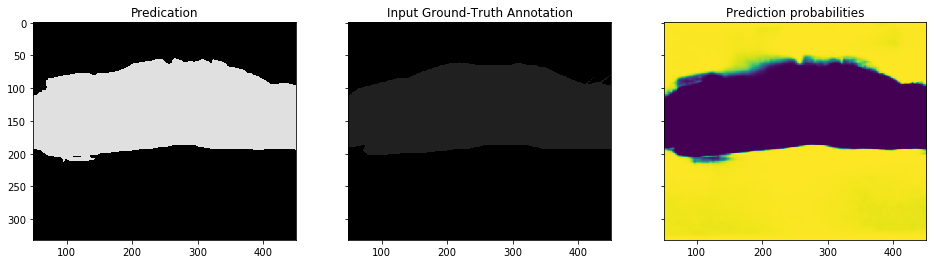

Train step: 18 	Traing Loss: 0.0720025 	mIOU: 0.0702592


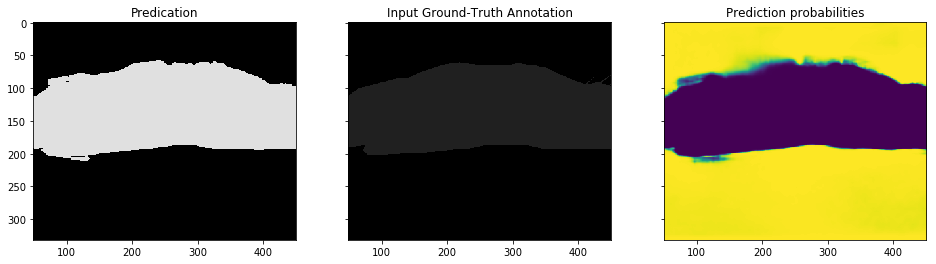

Train step: 19 	Traing Loss: 0.0582642 	mIOU: 0.0712656


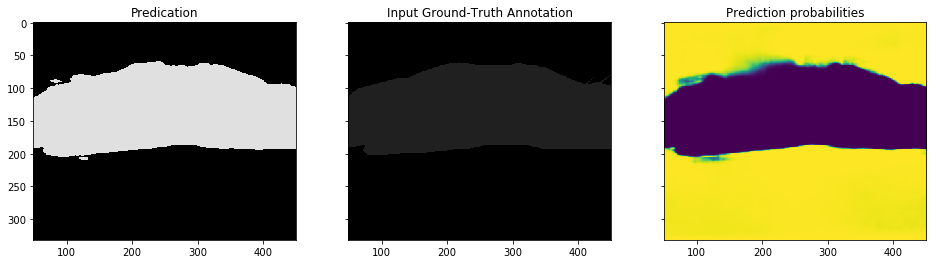

Train step: 20 	Traing Loss: 0.0535436 	mIOU: 0.0721829


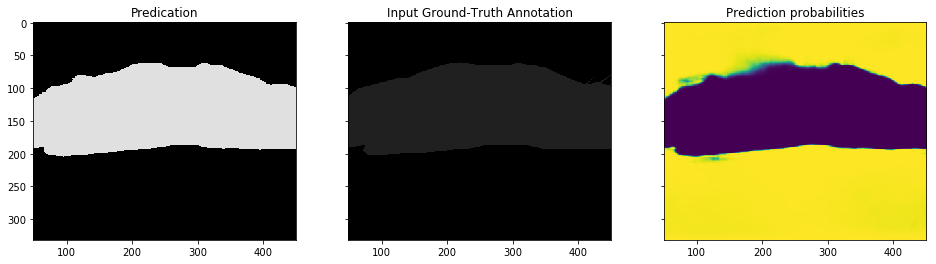

Train step: 21 	Traing Loss: 0.0547895 	mIOU: 0.0730118


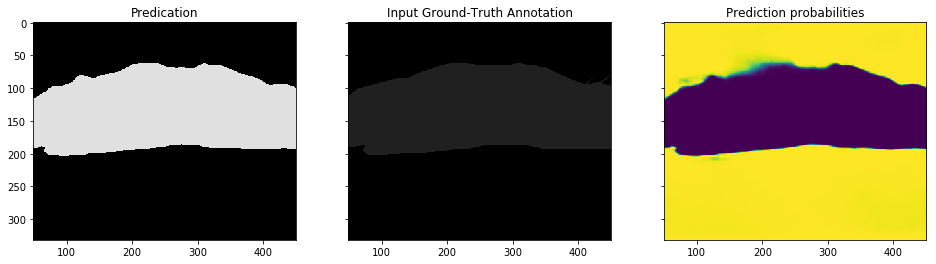

Train step: 22 	Traing Loss: 0.0576522 	mIOU: 0.0737672


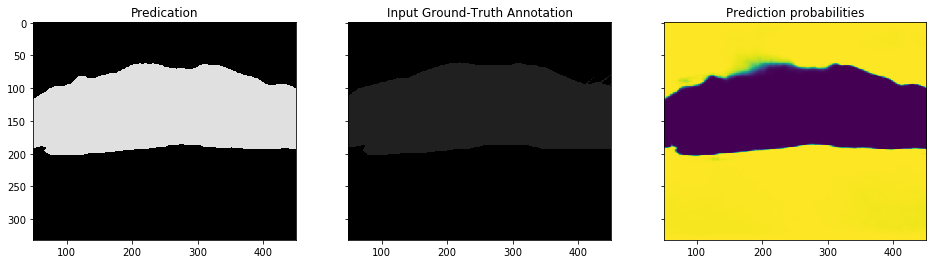

Train step: 23 	Traing Loss: 0.0586169 	mIOU: 0.074462


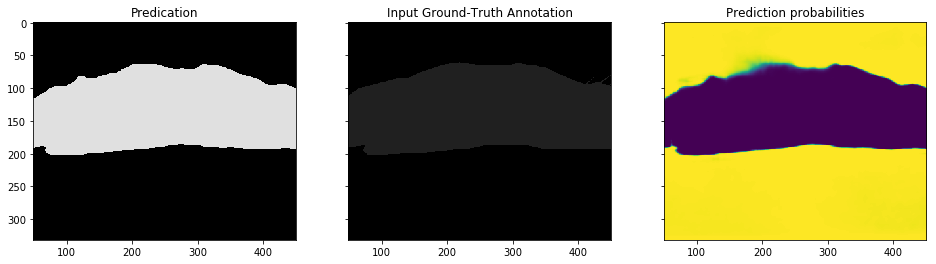

Train step: 24 	Traing Loss: 0.0563223 	mIOU: 0.0751096


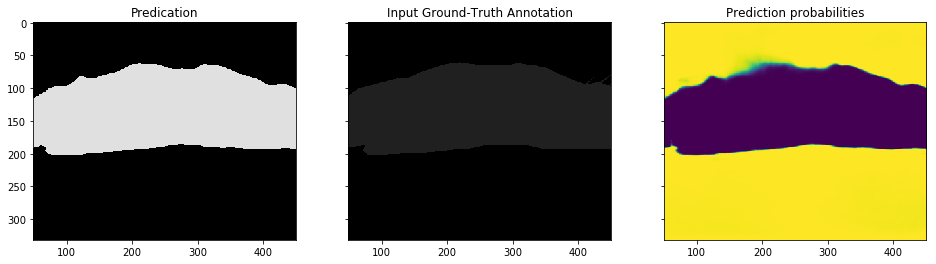

Train step: 25 	Traing Loss: 0.0512946 	mIOU: 0.0757216


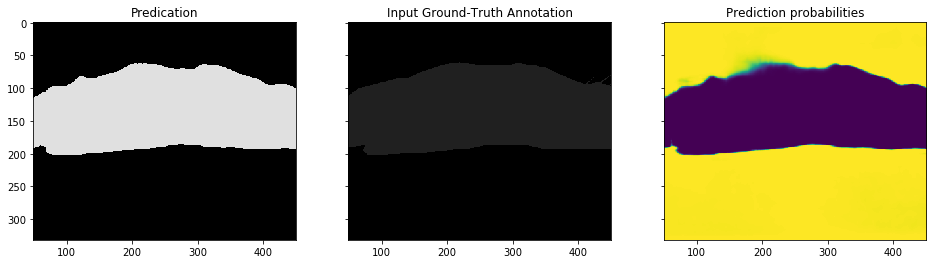

Train step: 26 	Traing Loss: 0.0451553 	mIOU: 0.0763038


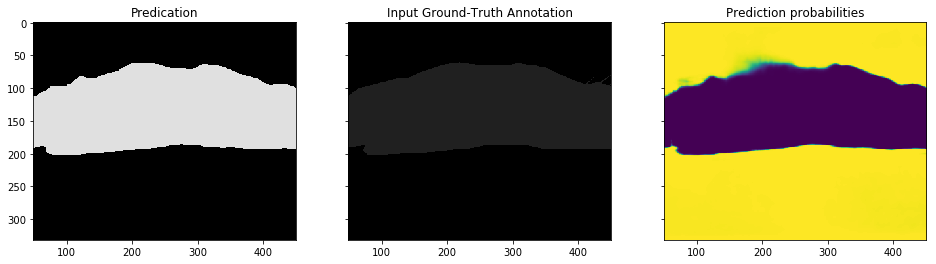

Train step: 27 	Traing Loss: 0.0395836 	mIOU: 0.0768573


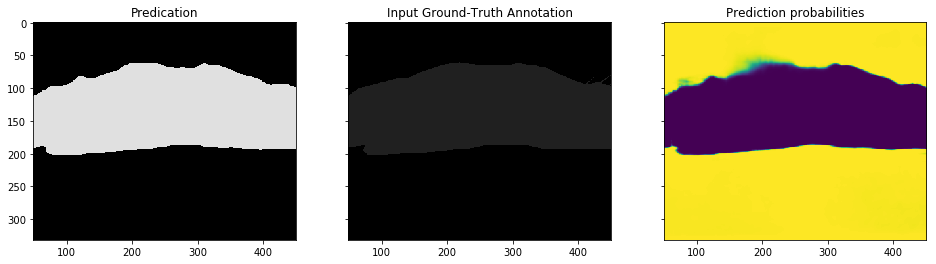

Train step: 28 	Traing Loss: 0.0359038 	mIOU: 0.0773794


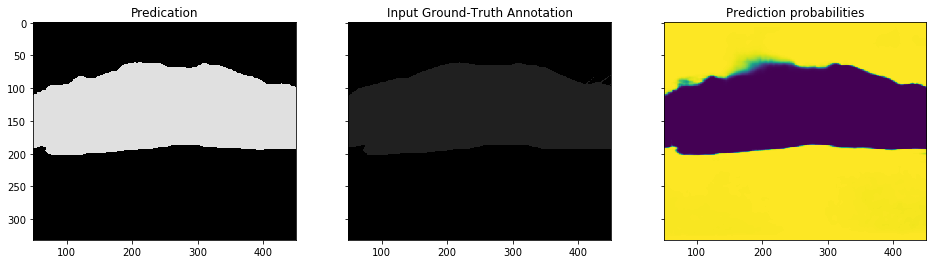

Train step: 29 	Traing Loss: 0.0345403 	mIOU: 0.077868


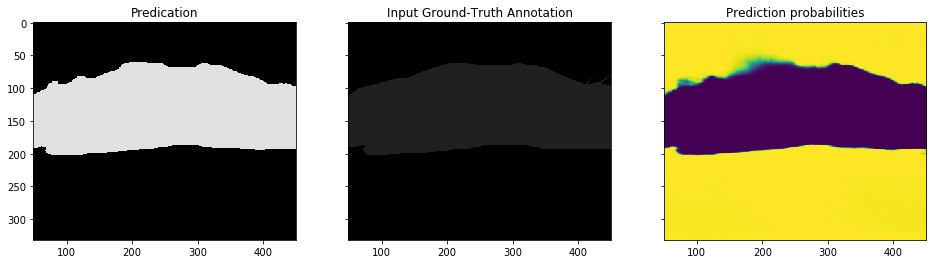

Train step: 30 	Traing Loss: 0.0347861 	mIOU: 0.0783242


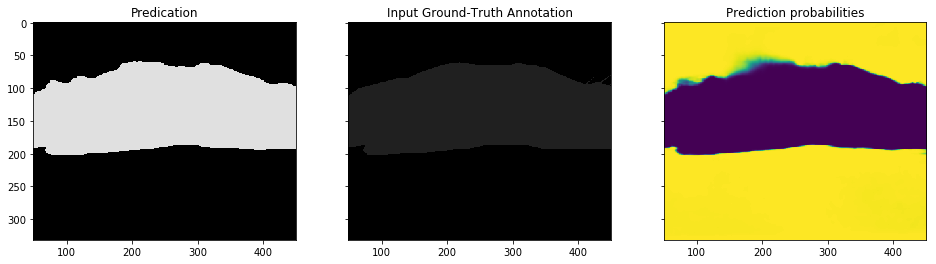

Train step: 31 	Traing Loss: 0.0352306 	mIOU: 0.0787515


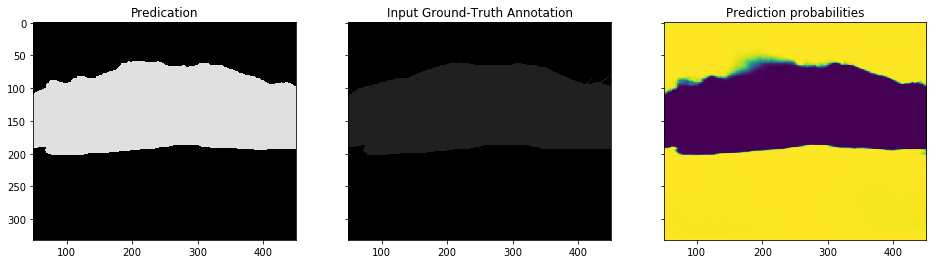

Train step: 32 	Traing Loss: 0.0347612 	mIOU: 0.0791541


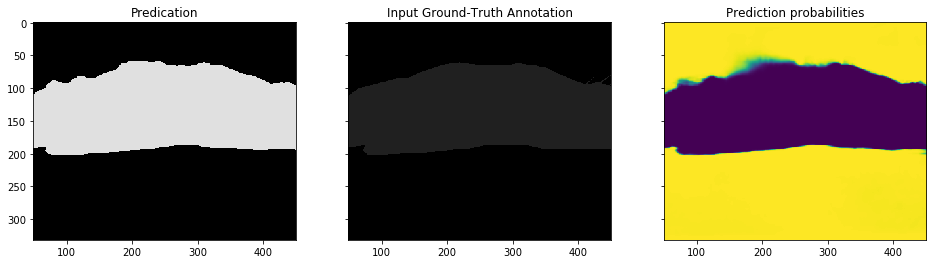

Train step: 33 	Traing Loss: 0.0330884 	mIOU: 0.079537


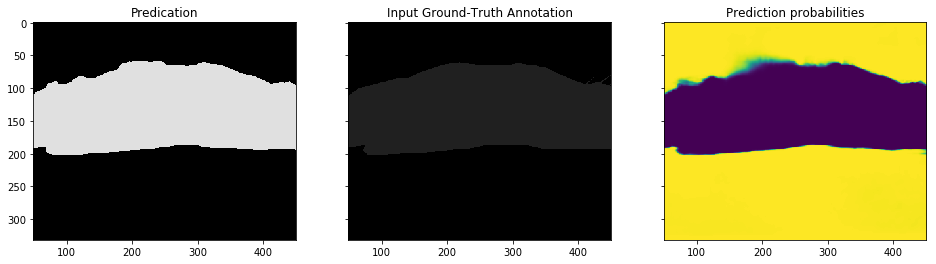

Train step: 34 	Traing Loss: 0.0306288 	mIOU: 0.079904


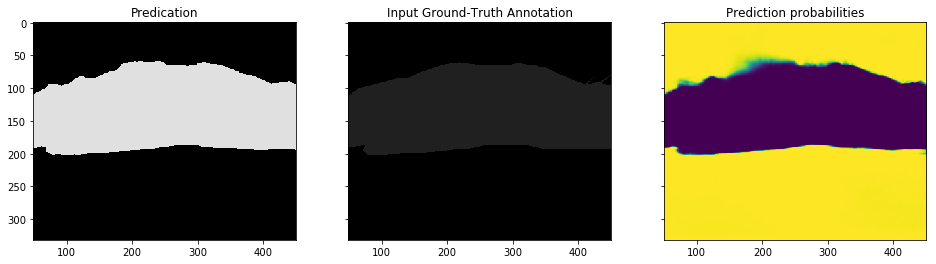

Train step: 35 	Traing Loss: 0.0281688 	mIOU: 0.0802551


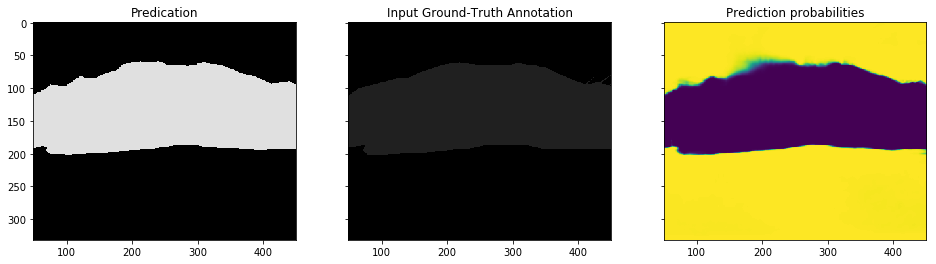

Train step: 36 	Traing Loss: 0.0263959 	mIOU: 0.080591


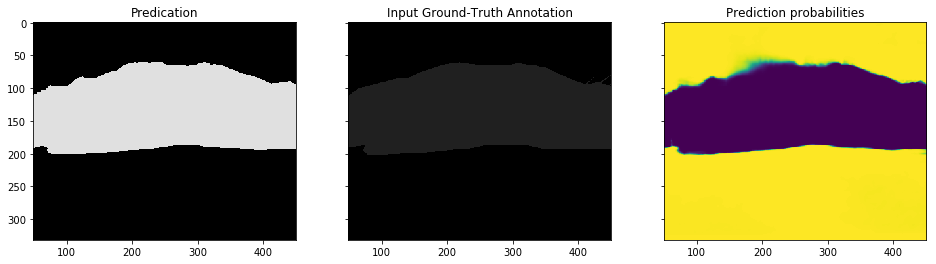

Train step: 37 	Traing Loss: 0.0255835 	mIOU: 0.0809111


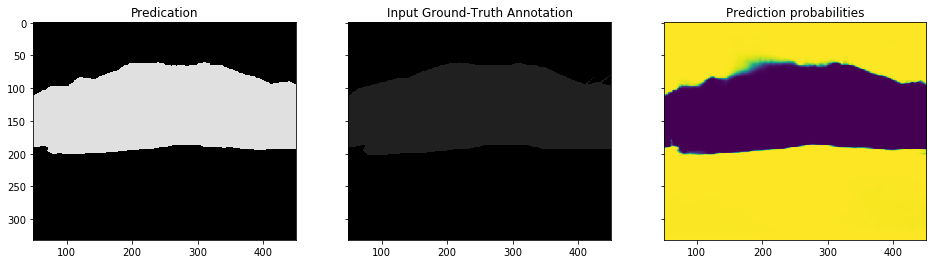

Train step: 38 	Traing Loss: 0.0255245 	mIOU: 0.0812152


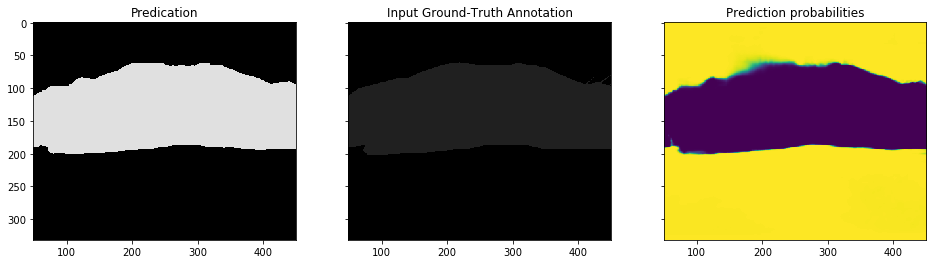

Train step: 39 	Traing Loss: 0.025715 	mIOU: 0.0815042


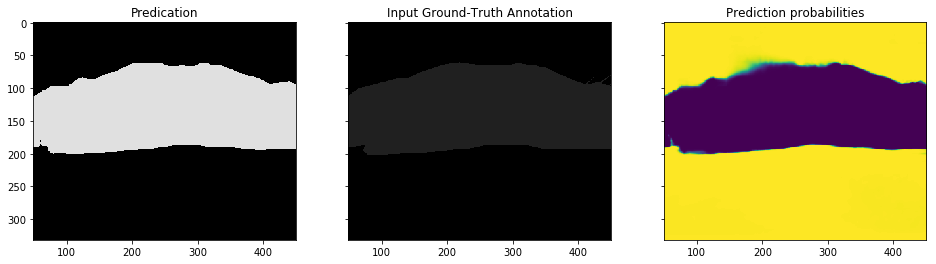

Train step: 40 	Traing Loss: 0.0256371 	mIOU: 0.0817794


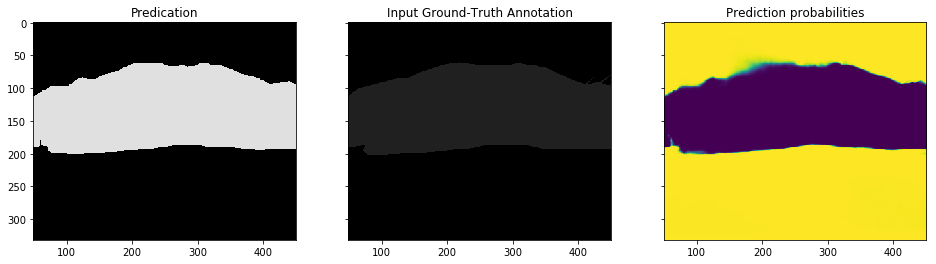

Train step: 41 	Traing Loss: 0.0250188 	mIOU: 0.0820423


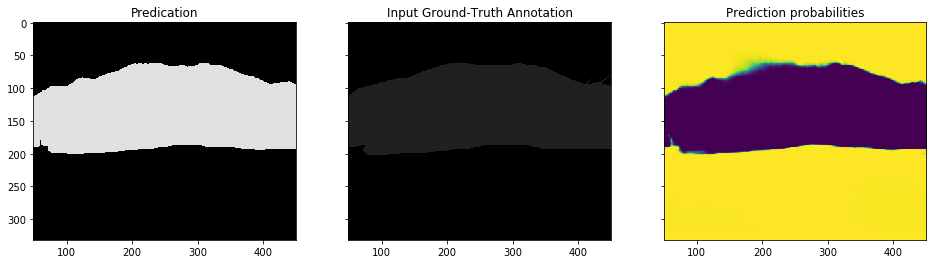

Train step: 42 	Traing Loss: 0.0239031 	mIOU: 0.0822952


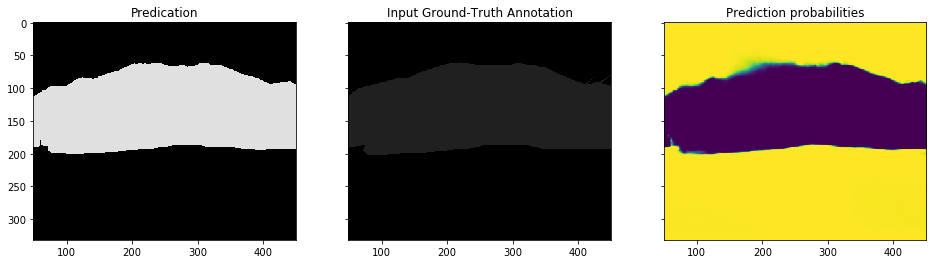

Train step: 43 	Traing Loss: 0.0226075 	mIOU: 0.0825393


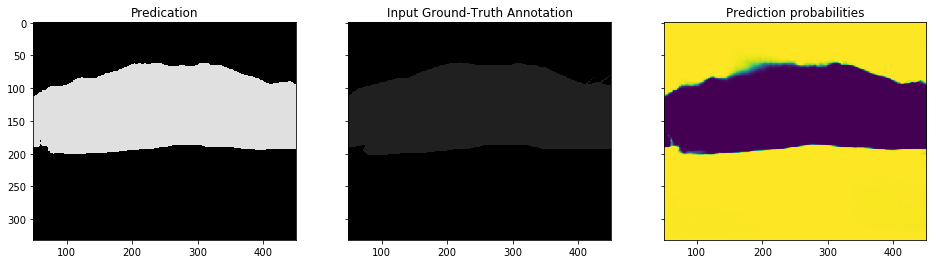

Train step: 44 	Traing Loss: 0.0215087 	mIOU: 0.0827756


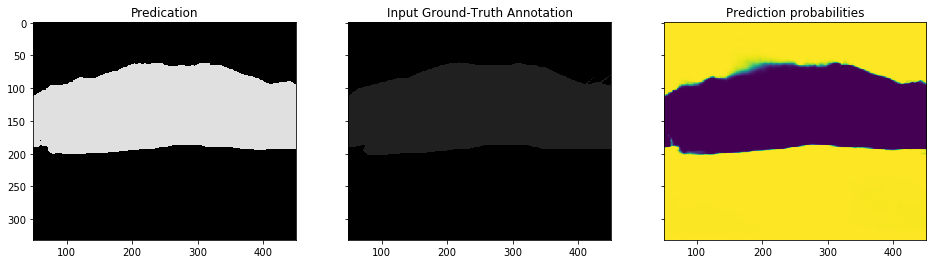

Train step: 45 	Traing Loss: 0.0208528 	mIOU: 0.083004


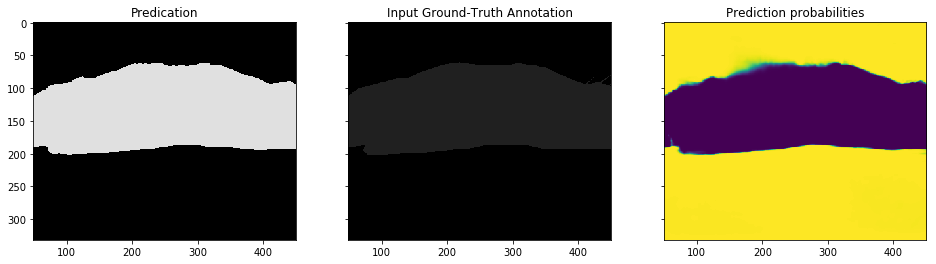

Train step: 46 	Traing Loss: 0.0206204 	mIOU: 0.0832238


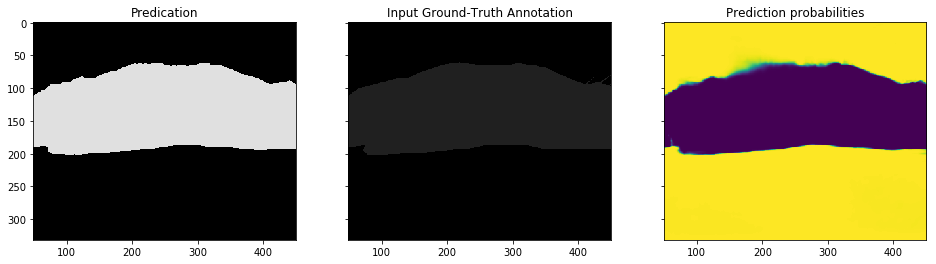

Train step: 47 	Traing Loss: 0.020585 	mIOU: 0.083435


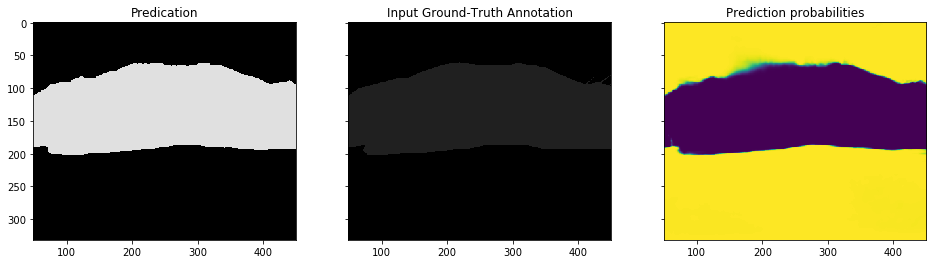

Train step: 48 	Traing Loss: 0.0204852 	mIOU: 0.0836387


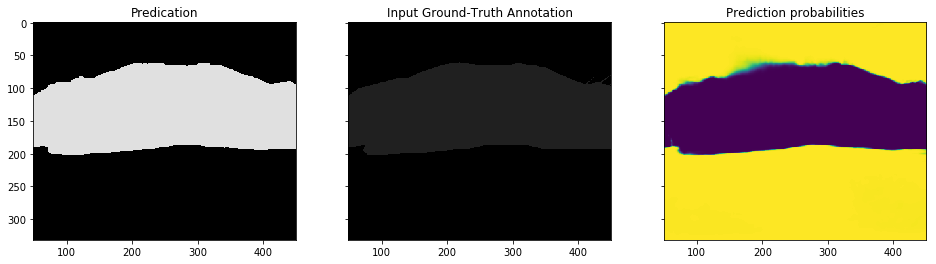

Train step: 49 	Traing Loss: 0.020168 	mIOU: 0.083835


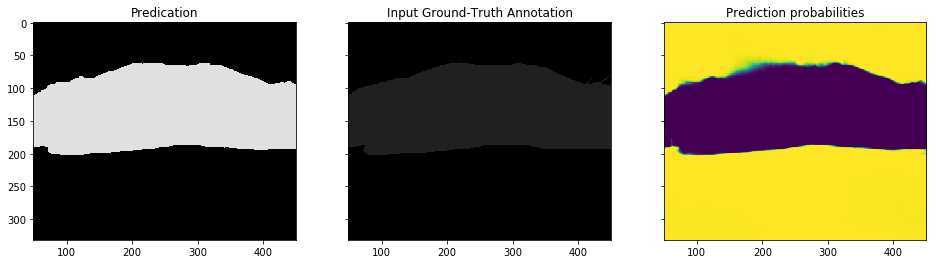

Train step: 50 	Traing Loss: 0.0196527 	mIOU: 0.0840247


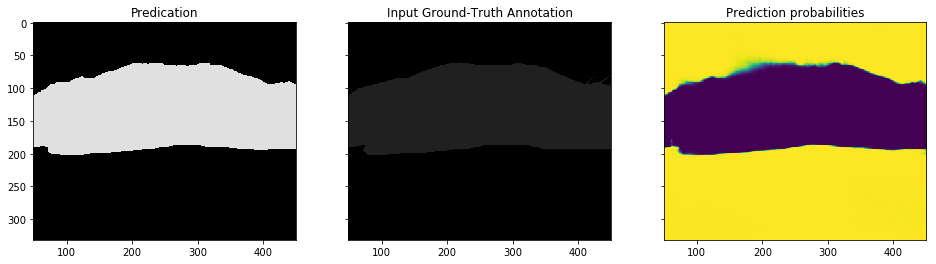

Train step: 51 	Traing Loss: 0.0190755 	mIOU: 0.0842074


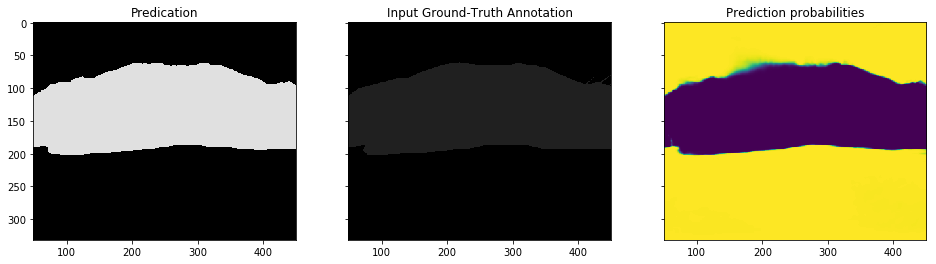

Train step: 52 	Traing Loss: 0.0185879 	mIOU: 0.0843844


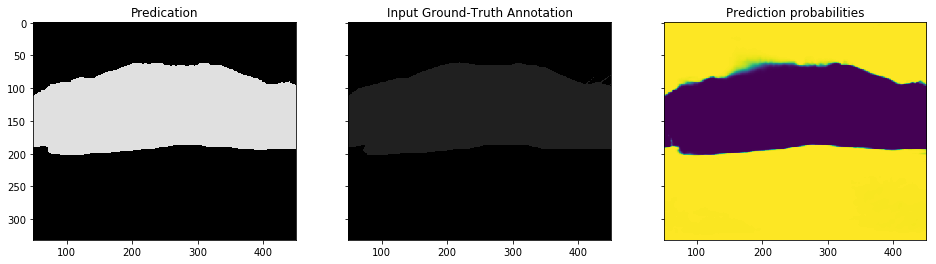

Train step: 53 	Traing Loss: 0.0182667 	mIOU: 0.0845555


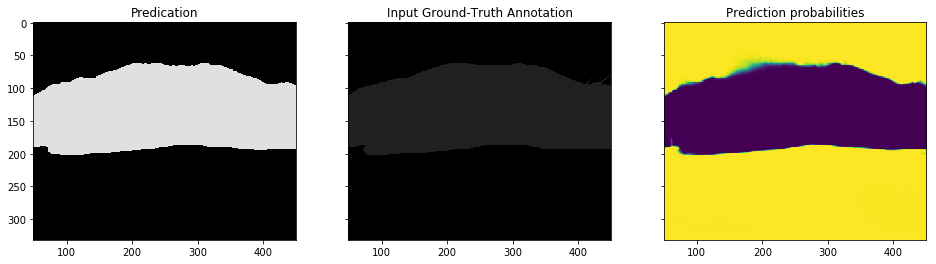

Train step: 54 	Traing Loss: 0.0180948 	mIOU: 0.0847211


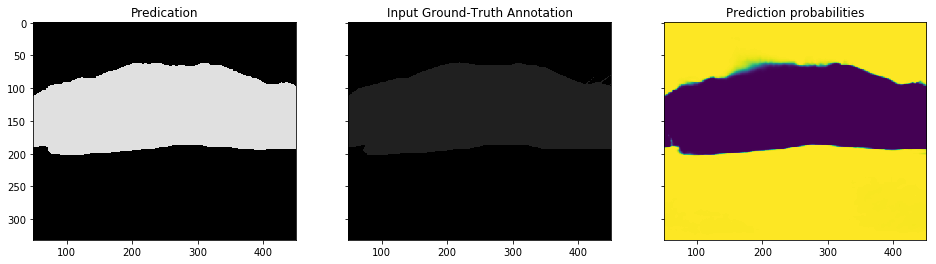

Train step: 55 	Traing Loss: 0.0179881 	mIOU: 0.0848812


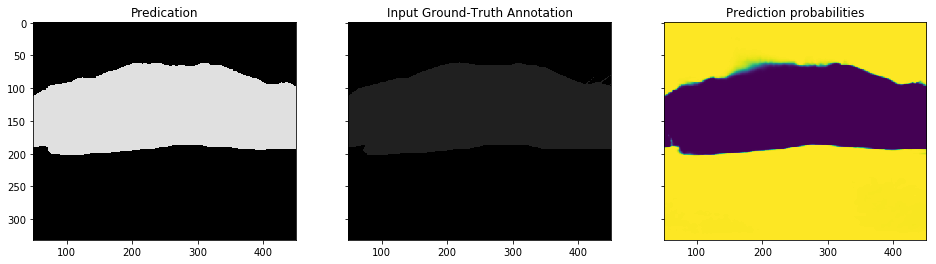

Train step: 56 	Traing Loss: 0.0178518 	mIOU: 0.085036


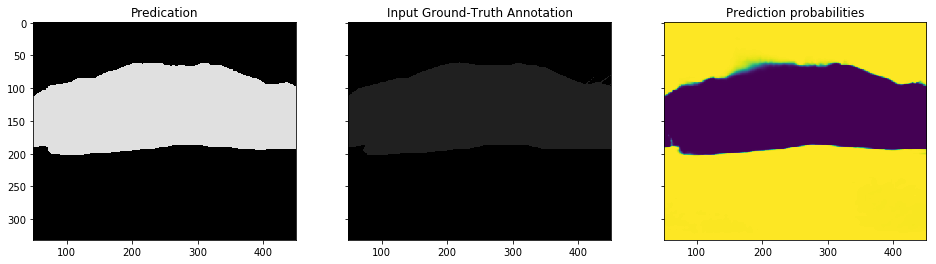

Train step: 57 	Traing Loss: 0.0176346 	mIOU: 0.0851862


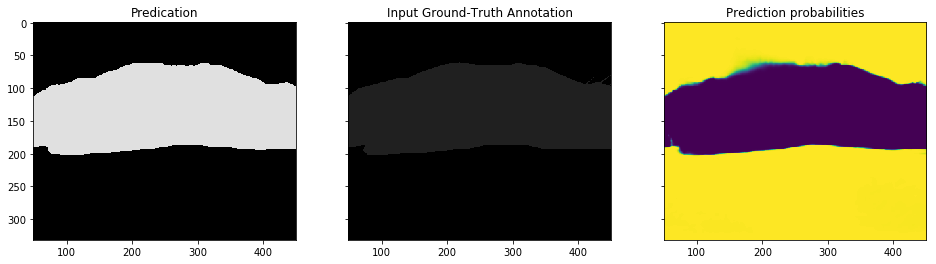

Train step: 58 	Traing Loss: 0.0173454 	mIOU: 0.085332


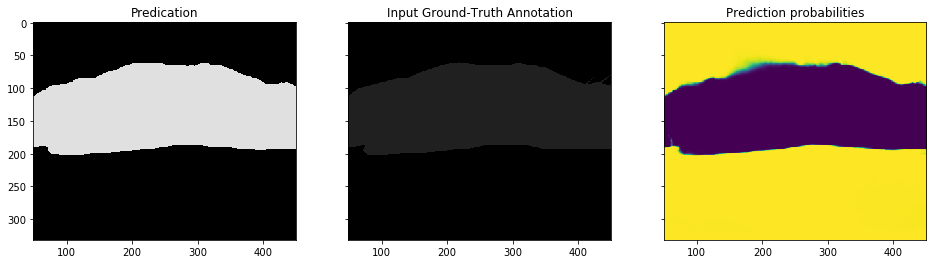

Train step: 59 	Traing Loss: 0.0170343 	mIOU: 0.0854731


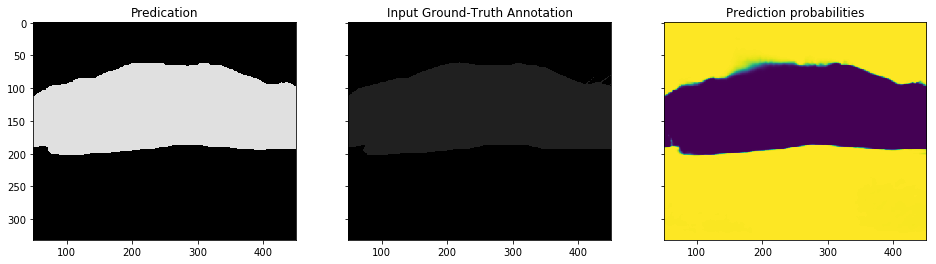

Train step: 60 	Traing Loss: 0.0167594 	mIOU: 0.0856101


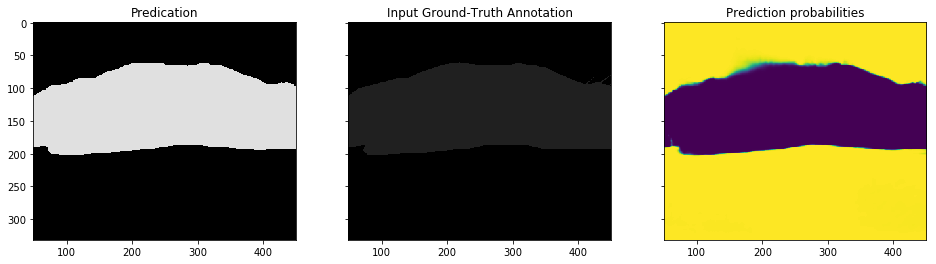

Train step: 61 	Traing Loss: 0.0165512 	mIOU: 0.085743


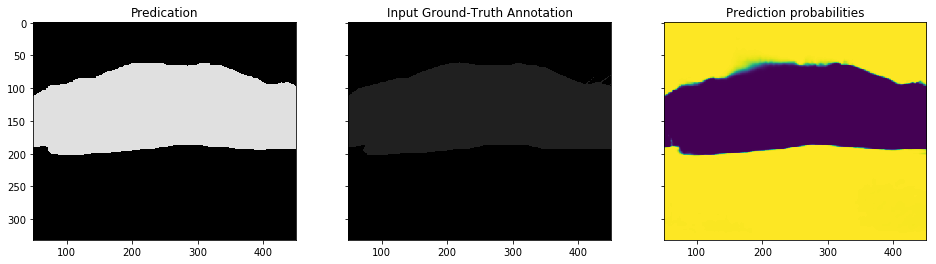

Train step: 62 	Traing Loss: 0.0163973 	mIOU: 0.0858718


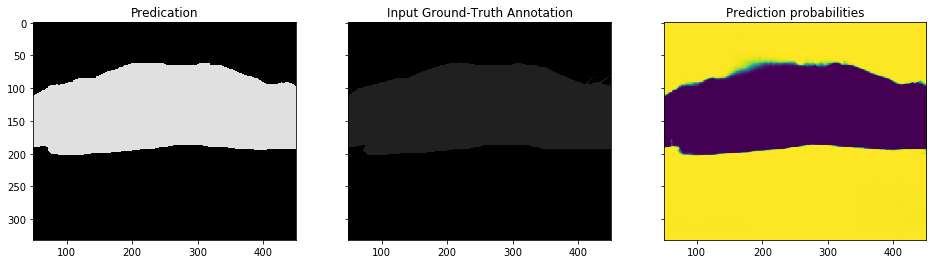

Train step: 63 	Traing Loss: 0.0162536 	mIOU: 0.0859968


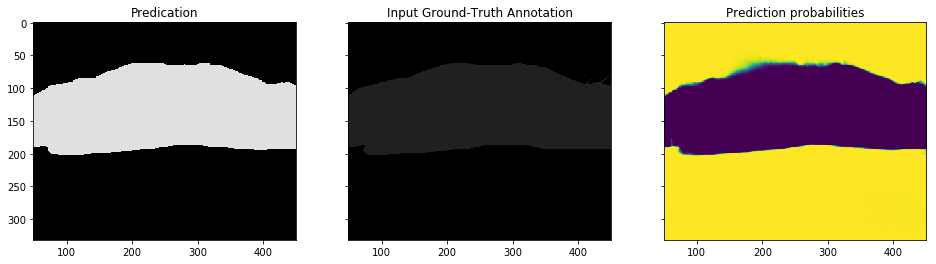

Train step: 64 	Traing Loss: 0.0160769 	mIOU: 0.0861184


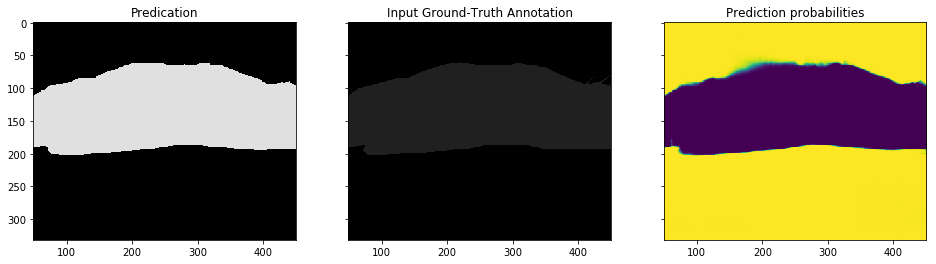

Train step: 65 	Traing Loss: 0.0158531 	mIOU: 0.0862367


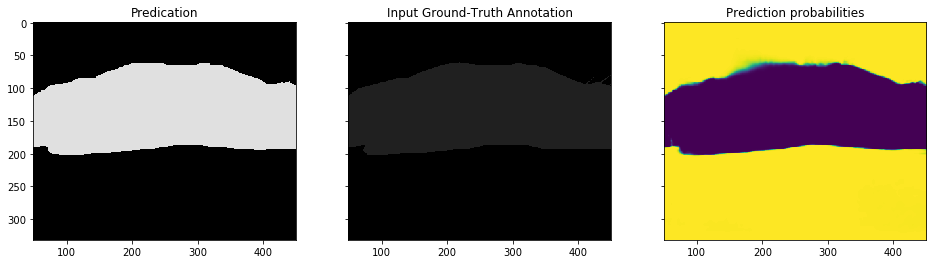

Train step: 66 	Traing Loss: 0.0156036 	mIOU: 0.0863517


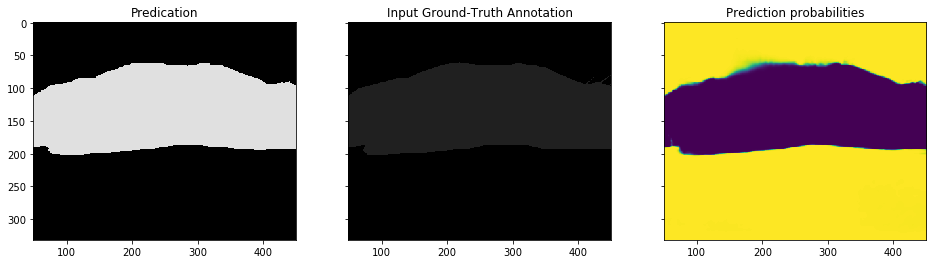

Train step: 67 	Traing Loss: 0.0153682 	mIOU: 0.0864637


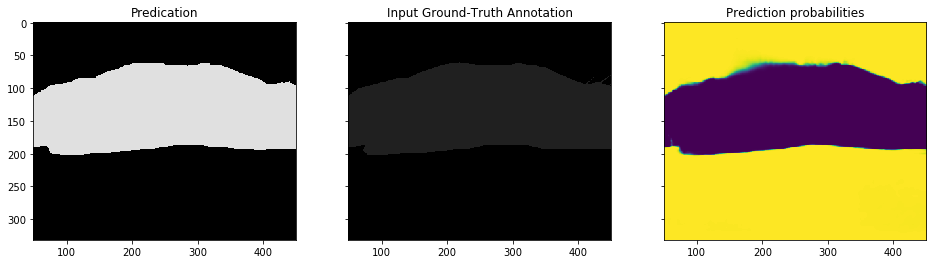

Train step: 68 	Traing Loss: 0.01518 	mIOU: 0.0865724


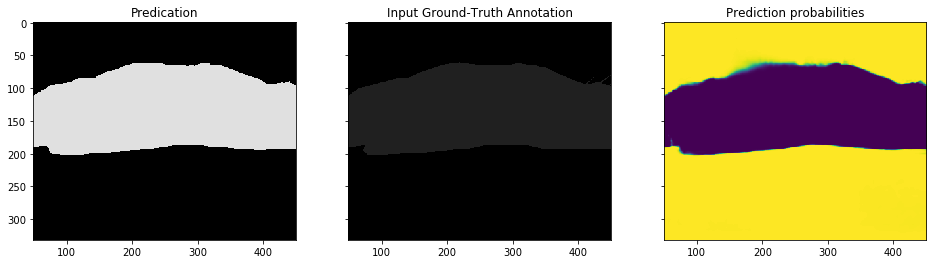

Train step: 69 	Traing Loss: 0.0150449 	mIOU: 0.0866783


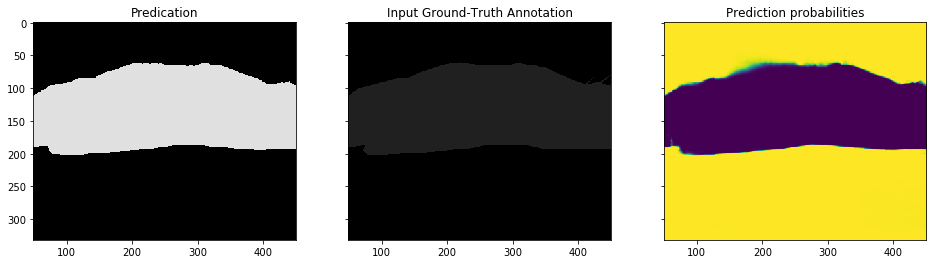

Train step: 70 	Traing Loss: 0.0149432 	mIOU: 0.0867813


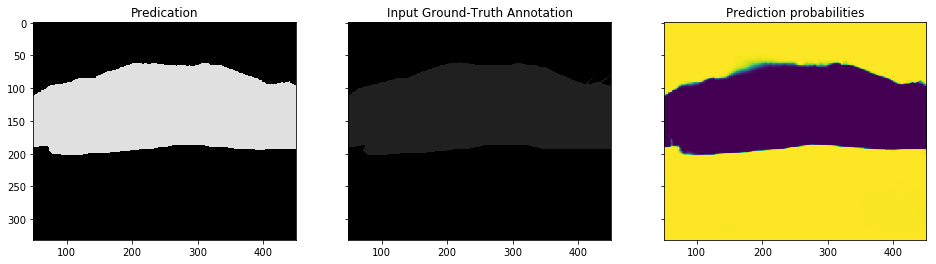

Train step: 71 	Traing Loss: 0.0148442 	mIOU: 0.0868814


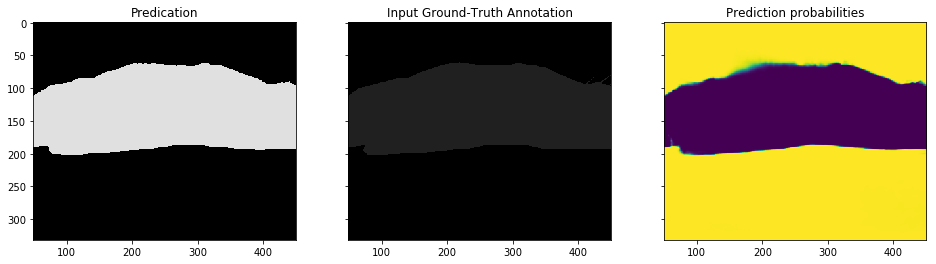

Train step: 72 	Traing Loss: 0.0147252 	mIOU: 0.086979


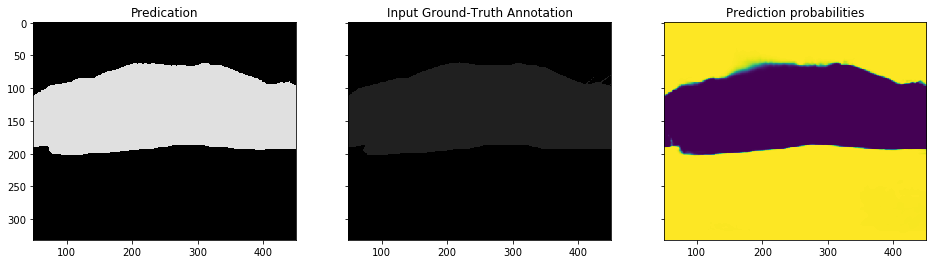

Train step: 73 	Traing Loss: 0.014582 	mIOU: 0.087074


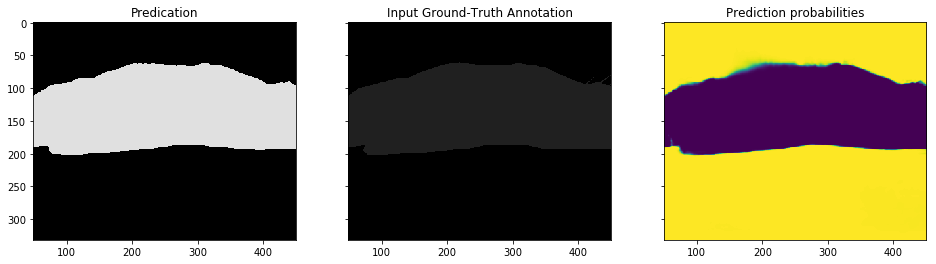

Train step: 74 	Traing Loss: 0.0144278 	mIOU: 0.0871667


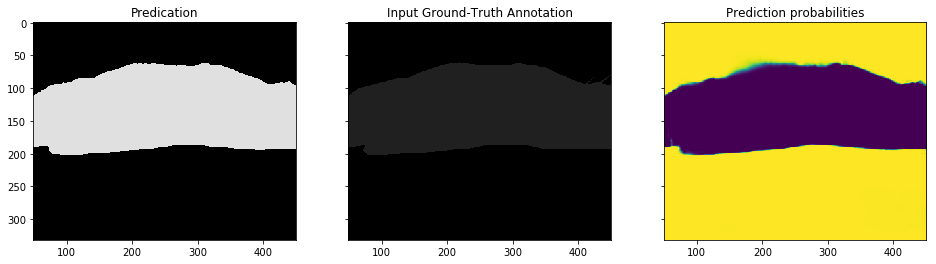

Train step: 75 	Traing Loss: 0.0142806 	mIOU: 0.0872572


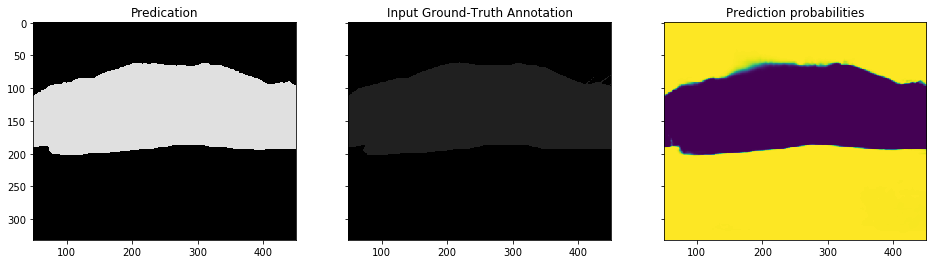

Train step: 76 	Traing Loss: 0.0141508 	mIOU: 0.0873456


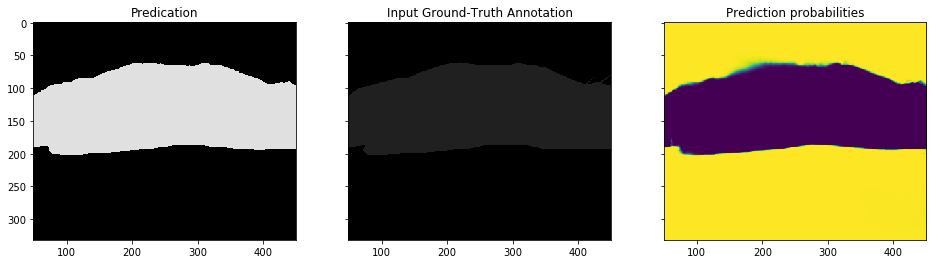

Train step: 77 	Traing Loss: 0.0140371 	mIOU: 0.0874319


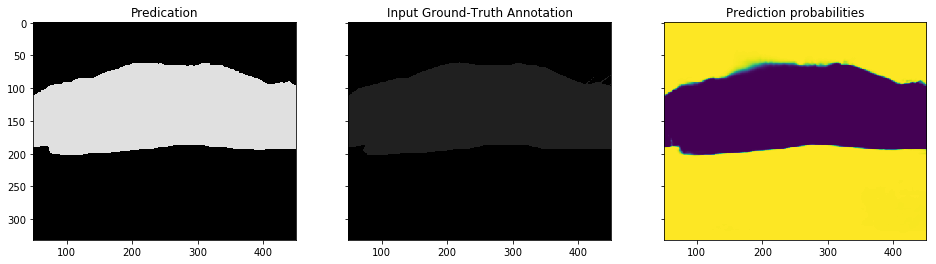

Train step: 78 	Traing Loss: 0.0139294 	mIOU: 0.0875161


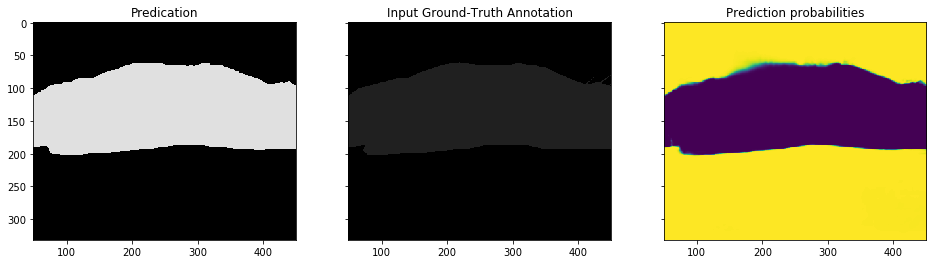

Train step: 79 	Traing Loss: 0.0138175 	mIOU: 0.0875983


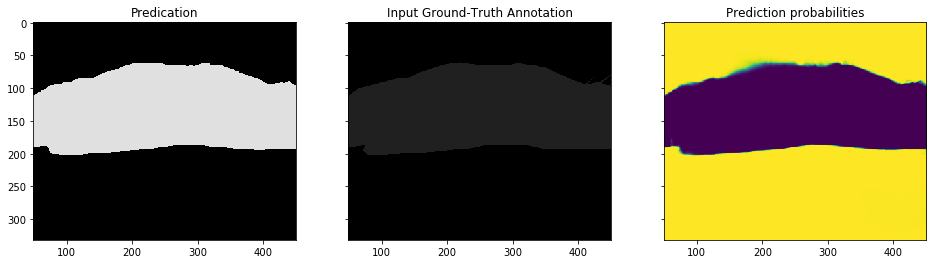

Train step: 80 	Traing Loss: 0.0136985 	mIOU: 0.0876786


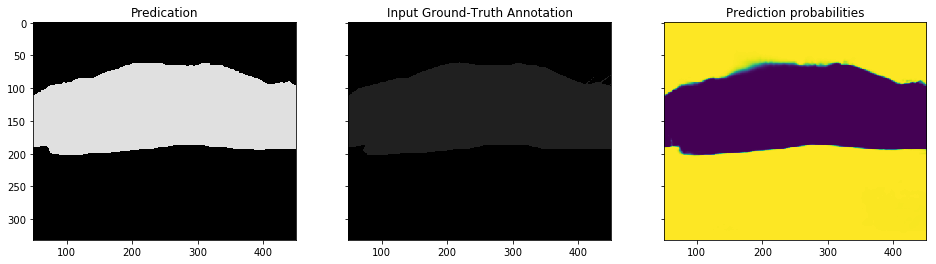

Train step: 81 	Traing Loss: 0.0135777 	mIOU: 0.0877571


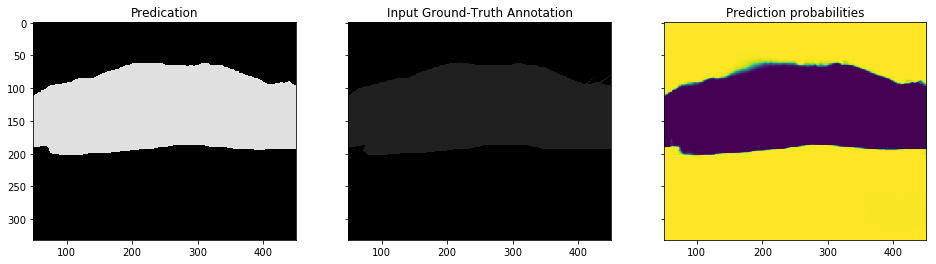

Train step: 82 	Traing Loss: 0.0134635 	mIOU: 0.0878338


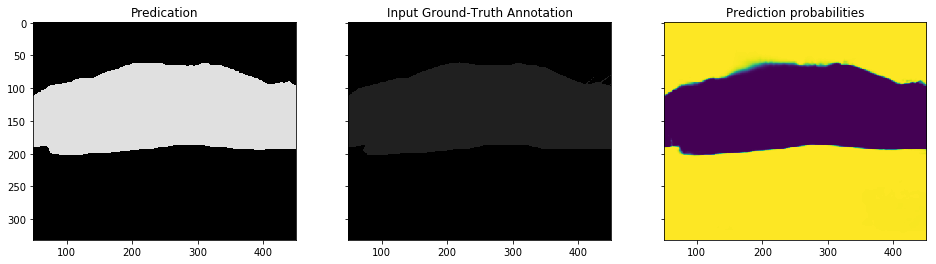

Train step: 83 	Traing Loss: 0.0133607 	mIOU: 0.0879089


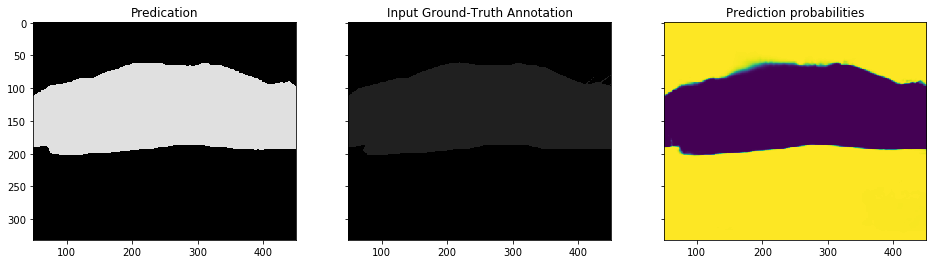

Train step: 84 	Traing Loss: 0.0132677 	mIOU: 0.0879825


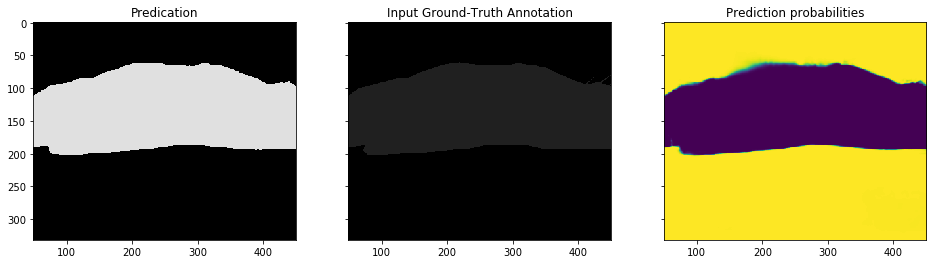

Train step: 85 	Traing Loss: 0.0131783 	mIOU: 0.0880544


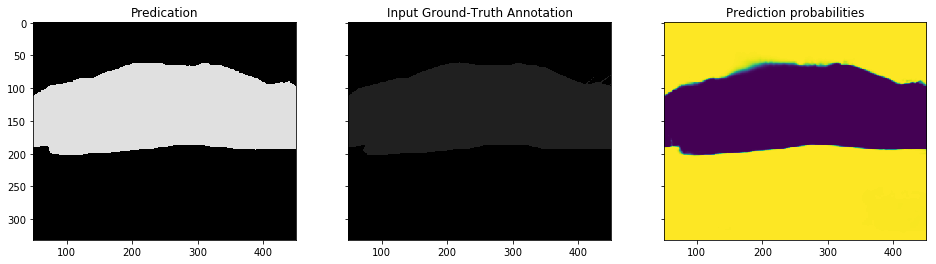

Train step: 86 	Traing Loss: 0.0130858 	mIOU: 0.0881248


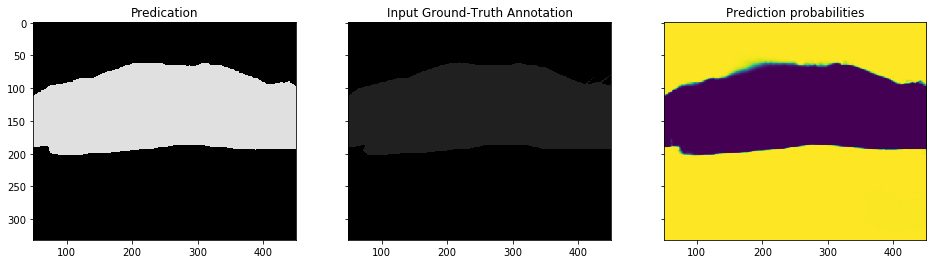

Train step: 87 	Traing Loss: 0.0129885 	mIOU: 0.0881938


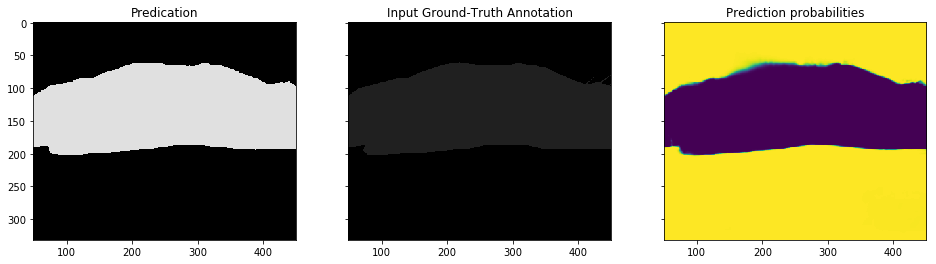

Train step: 88 	Traing Loss: 0.0128897 	mIOU: 0.0882613


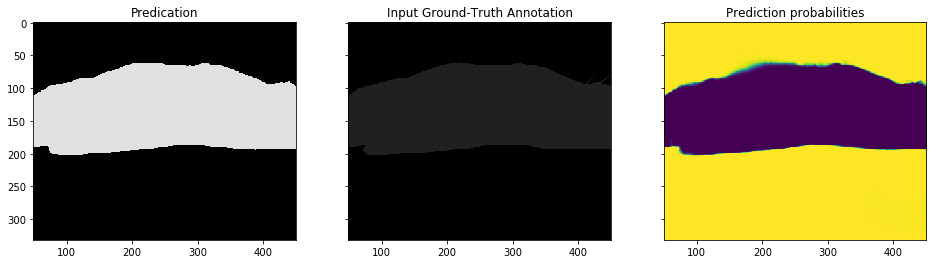

Train step: 89 	Traing Loss: 0.0127941 	mIOU: 0.0883275


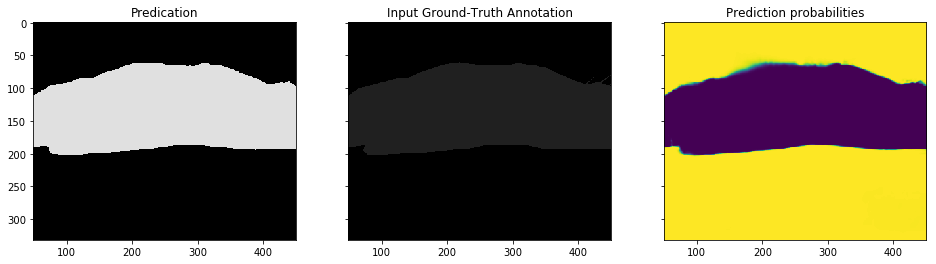

Train step: 90 	Traing Loss: 0.0127051 	mIOU: 0.0883923


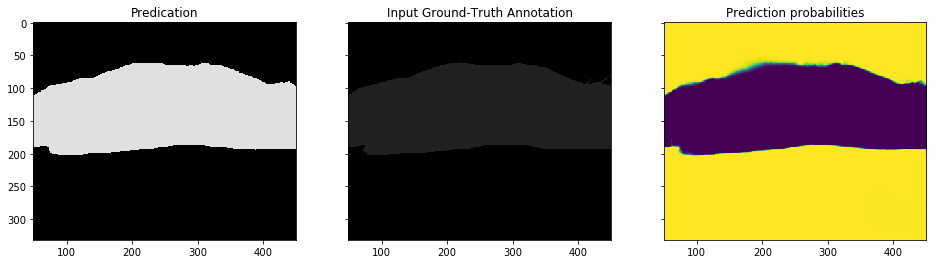

Train step: 91 	Traing Loss: 0.0126225 	mIOU: 0.0884558


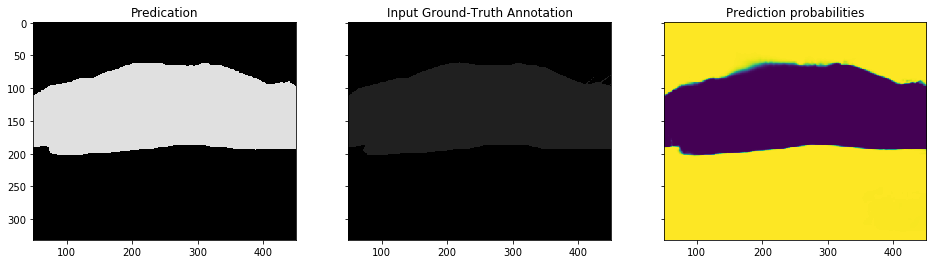

Train step: 92 	Traing Loss: 0.0125434 	mIOU: 0.088518


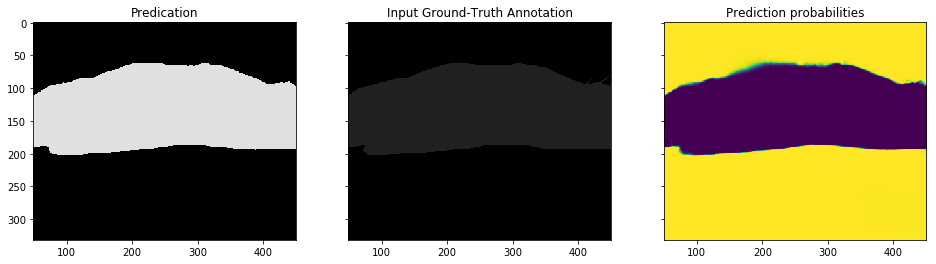

Train step: 93 	Traing Loss: 0.0124639 	mIOU: 0.088579


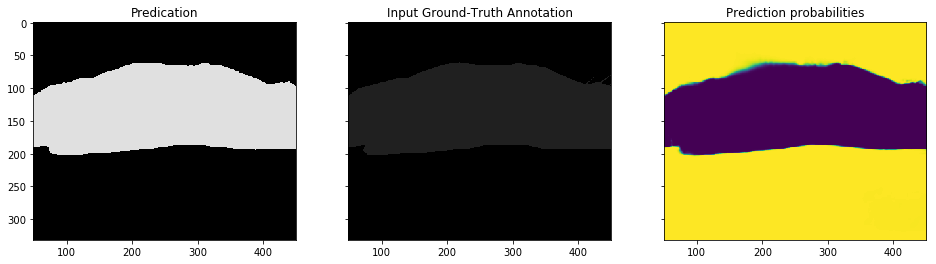

Train step: 94 	Traing Loss: 0.0123825 	mIOU: 0.0886387


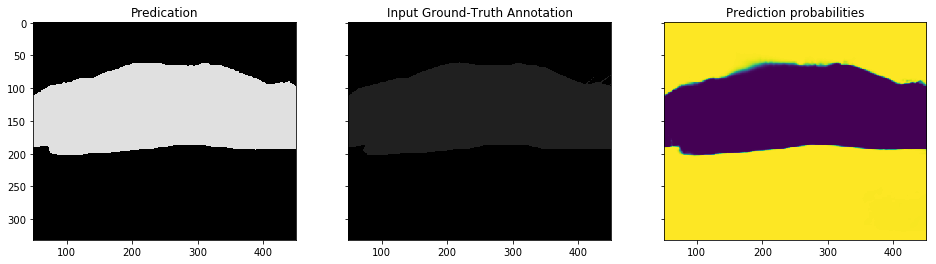

Train step: 95 	Traing Loss: 0.0123004 	mIOU: 0.0886973


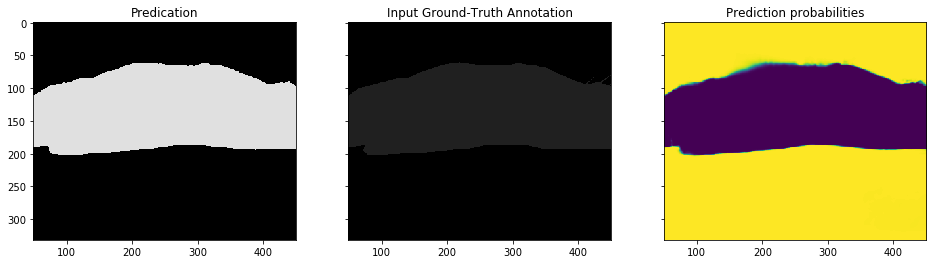

Train step: 96 	Traing Loss: 0.0122202 	mIOU: 0.0887547


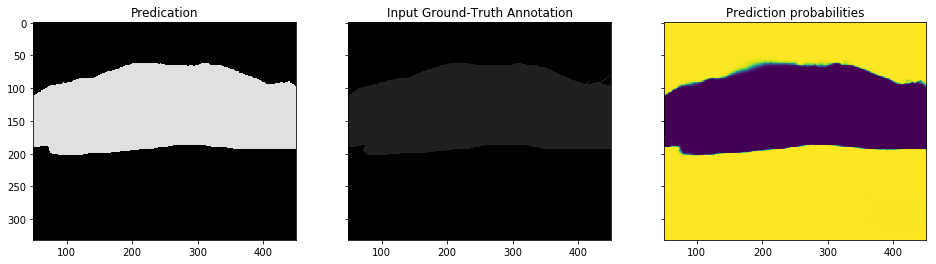

Train step: 97 	Traing Loss: 0.0121436 	mIOU: 0.088811


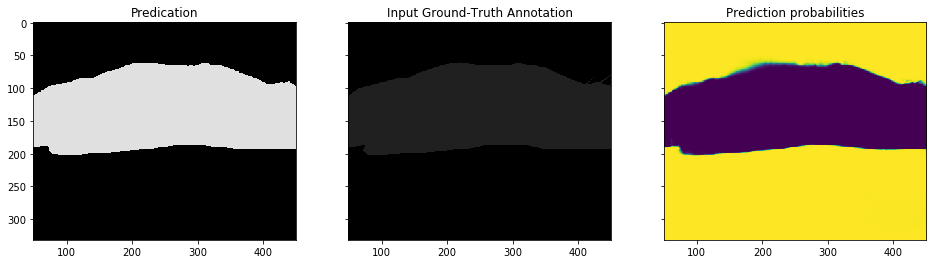

Train step: 98 	Traing Loss: 0.0120705 	mIOU: 0.0888663


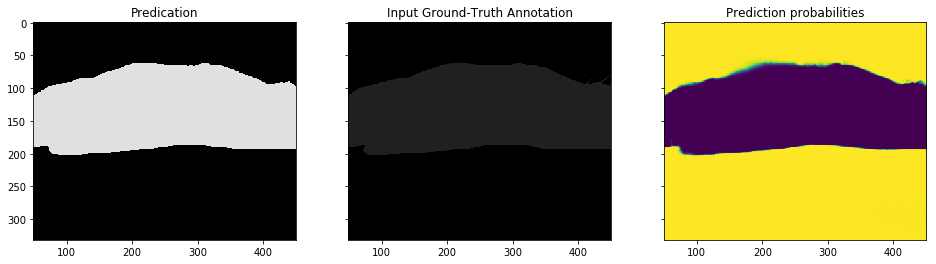

Train step: 99 	Traing Loss: 0.0119997 	mIOU: 0.0889204


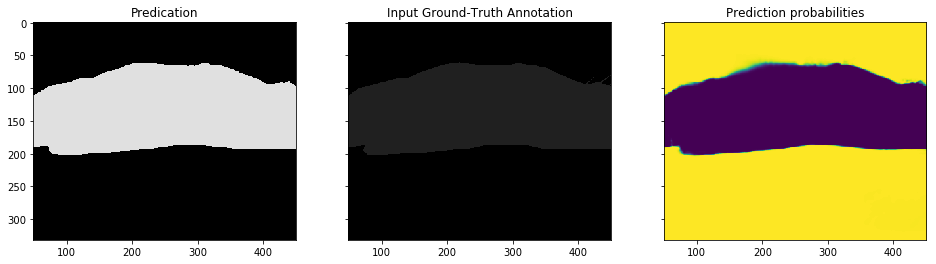

In [17]:
# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

model_vars = tf.variables_initializer(model_variables)

# Create a saver.
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    sess.run(tf.local_variables_initializer())
    sess.run(model_vars)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict={is_training_placeholder: False})
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figheight(4)
    f.set_figwidth(10)
    ax1.imshow(train_image[0])
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    for step in range(100):

        _, train_loss, pred_np, probabilities_np, tmp = sess.run([train_step, cross_entropy_sum, pred, probabilities, update_op],
                                        feed_dict={is_training_placeholder: True})
        miou_np = sess.run(miou)
        
        pred_annotation = np.expand_dims(pred_np[0], axis=2).astype(float)
        print("Train step:", step, "\tTraing Loss:", train_loss, "\tmIOU:", miou_np)

        cmap = plt.get_cmap('bwr')
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_figheight(4)
        f.set_figwidth(16)

        ax1.imshow(np.dstack((pred_annotation,)*3)*100)
        ax1.set_title('Predication')
        probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
        ax2.set_title('Input Ground-Truth Annotation')
        probability_graph = ax3.imshow(probabilities_np.squeeze()[:, :, 0])
        ax3.set_title('Prediction probabilities')
        plt.show()

    sess.close()

    summary_string_writer.close()

In [ ]:
with tf.Session() as sess:
    pred_np, probabilities_np, _, _ = sess.run([pred, probabilities, update_op, acc_update_op],
                                    feed_dict={is_training_placeholder: False})
    miou_np = sess.run(miou)
    accuracy = sess.run(acc)
    print("Accuracy:", accuracy, "miou:", miou)

In [24]:
unique_class_ids = set((pred_np[pred_np != 0]))
for class_id in unique_class_ids:
    print(class_semantic_labels[class_id])

aeroplane
